In [1]:
import sys
import pdb
# sys.path.insert allows us to define paths from where we can import .py files
sys.path.insert(0, r'D:\Programming\anaconda_jup_nb\5lsm0-CNN4CV\Assignment1') 

import mnist
import numpy as np
import matplotlib.pyplot as plt

We will download and save the MNIST dataset. Also, we will create our 'handwritten' folder for the final question. 

D.Guo: This is a large database of handwritten digits that is commonly used for training various image processing systems. 

In [2]:
mnist.init()

Download complete.
Save complete.


Let's load the data and inspect its dimensions. Make sure you understand what each dimension represents.

In [3]:
X_train, y_train, X_test, y_test = mnist.load()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


Lets plot some examples of the handwritten digits

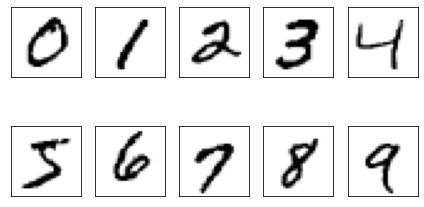

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Lets look at what different samples of the same digit looks like. You can change the label to look at other examples.

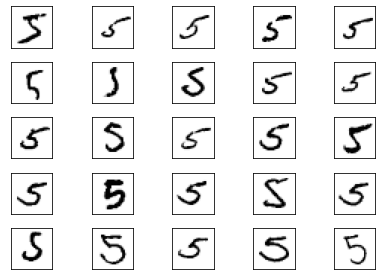

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 5][i].reshape(28, 28) # change the label to look at other digits
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_6.png', dpi=300)
plt.show()

### Q1. Evaluate several examples of the digits. Name three data-augmentation operations that make sense for this data set.

<span style="color:red">1. Geometric transformations - such as flip, crop or rotate.   
2. Kernel filters - Laplacian Gaussian filter to blur.   
3. Random Erasing - delete a part of the initial image.</span>.

If we look at the shape of the training data, we can see that the data is stored in vectorized form (The 28x28 pixel images are reshaped to a 1x784 array before storing). From the original 60.000 samples. The resulting shapes of the training data and training labels is what we expect. Performing sanity checks such as this is generally a good idea, it reduces the amount spent debugging when an inevitable bug shows up.

### Q2: Think of two other sanity checks you could perform (what expectations do we have about our data). Data can be ordinary images but also auxilary information such as for example the age of a patient with accompanying CT scan.

<span style="color:red">"""1. Take a random sample of data and plot it to check.  
2. We can also check original data dimensions and element value whether it is between 0-255."""</span>.

## Multi-layer perceptron
In this section we are going to implement our own multi-layer perceptron, including backpropagation. Carefully read all the hints in the code. The supplementary file will elaborate more on the details of the algorithm. You have to implement the following things:

1. the weight matrix initalizations
2. one-hot encoding
3. the sigmoid function
4. the forward pass
5. the cross-entropy cost function
6. the function that predicts (it uses the forward pass function and chooses the most likely prediction)
7. the function that fits the model on the data (it consist of the forwards pass, backpropagation algorithm and L2-regularization)

Before you start, really take your time to think about how your model should look and behave. What should the dimensions be of my weight and bias matrices? Why do I apply an activation function? How does one-hot encoding work with cross-entropy? It helps to also intermediatly print the sizes or values of you matrices to debug and confirm your code is working. For this, we have provided so called "sanity check" cells below the class cell.


In [26]:
import numpy as np
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training samples per minibatch.
    seed : int (default: None)
        Random seed for initalizing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, input_dim=784, n_hidden=30, n_classes=10,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.input_dim = input_dim
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

        # insert the proper dimensions for the initialization matrices. Use the class variables.
        self.b_h = np.random.normal(size=(self.n_hidden))
        self.b_out = np.random.normal(size=(self.n_classes))
        self.w_h = np.random.normal(size=(self.input_dim,self.n_hidden))
        self.w_out = np.random.normal(size=(self.n_hidden, self.n_classes))
                
    
    # the onehot function encodes labels into onehot representation e.g. with 3 labels, 0->[1,0,0], 1->[0,1,0], 2->[0,0,1]
    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)

        """
        # implement onehot encoding here. 

        #initializing onehot with all elements value equal to 0
        onehot = np.zeros([np.size(y),n_classes])
        for i in range(np.size(y)):
            onehot[i][int(y[i])] = 1 
        # HINT: We would like a n_samples x n_labels vector where each row
        # represents a sample vector with zeros everywhere except for position k, where index k equals the target value (0-9).
        
        return onehot

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        # implement sigmoid function here
        sigmoid_out = 1 / (1 + np.exp(-z).astype(np.float64))
        return sigmoid_out

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]-> [n_samples, n_hidden]
        z_h = np.dot(X,self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """

        '''
        # Loss (cost function)
        outputs = np.random.rand(7, 10)
        loss = test_model._compute_cost(onehot_vectors, outputs)
        print(loss) # should appr. be between 5 and 15
        '''
        
        # calculate the binary cross-entropy cost 
        cost = -np.sum(y_enc*np.log(output)+(1-y_enc)*np.log(1-output))
        cost = cost / output.shape[0]  + self.l2*(np.sum(self.w_out**2) + np.sum(self.w_h **2))
        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        # implement prediction here
        _,_,_,a_out = self._forward(X)
        y_pred = np.zeros(a_out.shape[0])
        for i in range(a_out.shape[0]):
            y_pred[i] = np.argmax(a_out[i][:])

        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_samples]
            Target class labels.
        X_valid : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_samples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))
        
        # create dictionary to keep track of training scores
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        
        # convert y to one-hot encoding
        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)
            
            # this for loop takes care of the batching process. Every iteration several samples are fed through the network in one go.
            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # calculate error vector of the output layer: sigma_out, [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]
                
                # calculate derivative of the sigmoid activation function:
                # sigmoid_derivative_h, [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1-a_h)

                # Calculate the error term of the hidden layer: sigma_h, 
                #[n_samples, n_classlabels] dot [n_classlabels, n_hidden] -> [n_samples, n_hidden]
                sigma_h = np.dot(sigma_out,self.w_out.T) * sigmoid_derivative_h  #shapes (100,120) and (100,100) not aligned: 120 (dim 1) != 100 (dim 0)

                # Calculate the gradients of the weights in the hidden layer
                # [n_features, n_samples] dot [n_samples, n_hidden] -> [n_features, n_hidden]

                grad_w_h = np.dot(X_train[batch_idx].T,sigma_h) 

                # calculate gradients of the biases in the hidden layer (freebee)
                grad_b_h = np.sum(sigma_h, axis=0)

                # Calculate the gradients of the weights in the output layer
                # [n_hidden, n_samples] dot [n_samples, n_classlabels] -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T,sigma_out)
                # calculate the gradient of the biases in the output layer
                grad_b_out = np.sum(sigma_out, axis=0)

                # L2-regularization and weight updates (bias is not regularized)
                delta_w_h = grad_w_h + 2 * self.l2 * self.w_h 
                delta_b_h = grad_b_h 
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = grad_w_out + 2 * self.l2 * self.w_out
                delta_b_out = grad_b_out
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r' + '{}/{} | Cost: {:.1f} | Train/Valid Acc.: {:.2f}%/{:.2f}% '.format(i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

! SANITY CHECK AREA ! - You can check here wether your functions work as intended

In [18]:
test_model = NeuralNetMLP()

# Onehot encoding
labels = np.array([0., 3., 4., 5., 9., 4., 0.])
n_classes = 10
onehot_vectors = test_model._onehot(labels, n_classes)
print(onehot_vectors)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


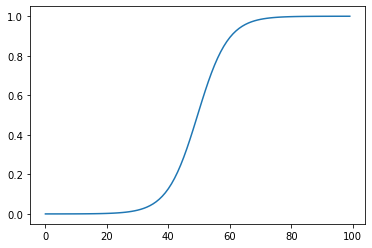

In [19]:
# Sigmoid activation
x = np.linspace(-10, 10, 100)
out = test_model._sigmoid(x)
plt.plot(out)
plt.show()

In [20]:
# Forward call
samples = np.random.normal(size=(50, 784)) # fake samples
z_h, a_h, z_out, a_out = test_model._forward(samples)
print(z_h.shape, a_h.shape, z_out.shape, a_out.shape)

(50, 30) (50, 30) (50, 10) (50, 10)


In [21]:
# Loss (cost function)
outputs = np.random.rand(7, 10)
loss = test_model._compute_cost(onehot_vectors, outputs)
print(loss) # should appr. be between 5 and 15

7.7063859121003295


In [22]:
# Predictions - the predictions make no sense at this point of course!
predictions = test_model.predict(samples)
print(predictions)

[3. 2. 6. 6. 0. 3. 3. 6. 6. 2. 1. 6. 0. 3. 2. 0. 3. 2. 3. 2. 3. 6. 3. 3.
 0. 2. 6. 2. 3. 6. 6. 2. 3. 2. 6. 8. 2. 6. 3. 3. 1. 3. 0. 2. 0. 3. 0. 0.
 7. 2.]


Lets initialize the network and feed it training and validation data (55000 samples are used for training, remaining 5000 samples are used for validation).
### Q3. Why do we define a validation set even though we already have a test set of unseen samples? Explain your answer.
<span style="color:red">'''  The validation set is often used to evaluate model performance when tuning the hyperparameters. While the test set of unseen sampels is used to evaluate whether the model can generalize well.'''</span>.

In [27]:
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.0001, 
                  epochs=20, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)
#change n_hidden to 120 from 100
nn.fit(X_train=X_train[:50000], 
       y_train=y_train[:50000],
       X_valid=X_train[50000:],
       y_valid=y_train[50000:])

C:\Users\DETIAN~1\AppData\Local\Temp/ipykernel_9572/1917489371.py:82: RuntimeWarning: overflow encountered in exp
  sigmoid_out = 1 / (1 + np.exp(-z).astype(float))
C:\Users\DETIAN~1\AppData\Local\Temp/ipykernel_9572/1917489371.py:268: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
C:\Users\DETIAN~1\AppData\Local\Temp/ipykernel_9572/1917489371.py:270: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.

Lets plot the cost and the training/validation accuracy for 20 epochs. We can see the cost is decreasing and accuracy of both the training and validation is going up.

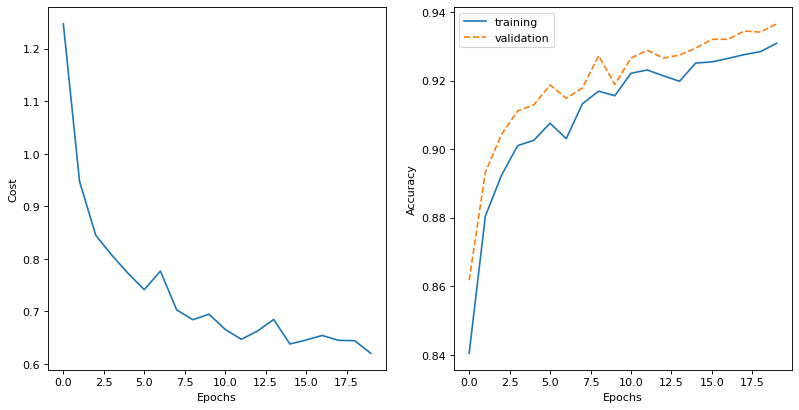

In [28]:
fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,2,1)
ax.plot(range(nn.epochs), nn.eval_['cost'])
ax.set_ylabel('Cost')
ax.set_xlabel('Epochs')

ax = plt.subplot(1,2,2)
ax.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='training')
ax.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='validation', linestyle='--')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.legend()
plt.show()


## Q4. The validation accuracy is higher than the training accuracy. What does this say about the quality of the model?
<span style="color:red">'''Normally the validation data set is used for tuning the hyperparameters. In this case, we did not do that. The validation dataset is not seen during training. So the higher validation accuracy said that the model generalized well.  
The validation accuracy is indeed higher than the training accuracy if the regularization term is deleted in the function _compute_cost()(,but the regularizer for gradient in fit() is not correspondingly deleted). And it maybe because minibatch method of this model change the distribution of data. The validation dataset is more representative for the distribution.   
But when the regularizer with l2=0.001 is added back, the cost went up...
Comparing these two results, I tried a smaller l2 = 0.0001. The cost went down as following plot shows. This time the validation accuracy is lower than the training accuracy(Train/Valid Acc.: 96.29%/95.86%), which is acceptable i assume.'''</span>.

In [30]:
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.0001, 
                  epochs=200, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=123)

nn.fit(X_train=X_train[:50000], 
       y_train=y_train[:50000],
       X_valid=X_train[50000:],
       y_valid=y_train[50000:])

C:\Users\DETIAN~1\AppData\Local\Temp/ipykernel_9572/1917489371.py:82: RuntimeWarning: overflow encountered in exp
  sigmoid_out = 1 / (1 + np.exp(-z).astype(float))
C:\Users\DETIAN~1\AppData\Local\Temp/ipykernel_9572/1917489371.py:268: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
C:\Users\DETIAN~1\AppData\Local\Temp/ipykernel_9572/1917489371.py:270: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.

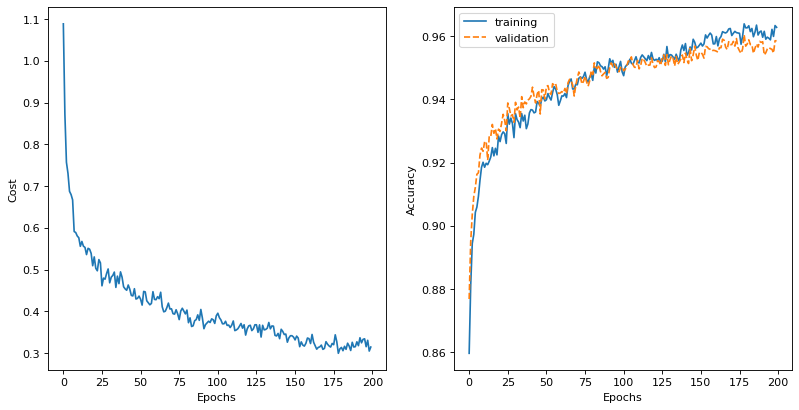

In [31]:
fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,2,1)
ax.plot(range(nn.epochs), nn.eval_['cost'])
ax.set_ylabel('Cost')
ax.set_xlabel('Epochs')

ax = plt.subplot(1,2,2)
ax.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='training')
ax.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='validation', linestyle='--')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.legend()
plt.show()

## Q5. The neural network is getting pretty good results on the data. What changes in the architecture or training procedure could you change in order to improve on the results further?

<span style="color:red">'''1. Change the linear hidden layer to convolutional layer to abstract features from input.   
2. Add more convolutional layers. Since the first hidden layer may abstract features like lines and edges. The second hidden layer can abstract higher-level features which would fit in the task hand-written number better.   
3. Train with smaller batch size which leads to more update in the weights and biases. This may also improve on the results.'''
</span>

## Q6. We used accuracy as our evaluation metric but there are many other metrics we can evaluate on. Explain the possible pitfalls of only relying on accuracy with an example. Suggest other metrics we can use to see if our model generalized well and explain what the metric evaluates on.

<span style="color:red">''' If we only rely on accuracy, we will ignore other important metrics such as precision and recall. For example, if we want to design a medical image processing model to diagnose an uncommon disease with a small possibility(99%), and the modell's accuracy can be 99% when its output simply is no one have this disease. But this modell is obviously losing its function.   
In this case, we should also take recall into consideration. That is to calculate the ration of true positive and the sum of true positive and false negative samples. Recall indicates how well the model predict true positive samples. '''</span>.

## Q7. We are now going to run inference with our own handwritten images. Create three replicas of MNIST digits (by using e.g. paint) and show what your model predicts.   

Put your png images in the 'handwritten/' folder. You can simply use paint to write on a 28x28 canvas. Try to match the images as closely to MNIST-style as possible. 

For information on MNIST: http://yann.lecun.com/exdb/mnist/ 

Matplotlib shows the images black on white but the images are actually <b>white on black!</b>

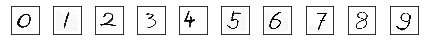

In [32]:
X_hw = mnist.handwritten()  # should be (N, 28, 28)

# Print handwritten digits
fig, ax = plt.subplots(nrows=1, ncols=X_hw.shape[0], sharex=True, sharey=True,)
ax = ax.flatten()
for i in range((X_hw.shape[0])):
    ax[i].imshow(X_hw[i,...], cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [39]:
# Run inference here and present predictions. 

# First reshape numpy array as our training data
samples_q7 = np.zeros((X_hw.shape[0],784))
for i in range(X_hw.shape[0]):
    samples_q7[i] = X_hw[i][:].reshape(28*28)
# Make predictions and present results
pred_q7 = nn.predict(samples_q7)
print(pred_q7)
acc_q7 = 0
for i in range(10):
    if i == pred_q7[i]:
        acc_q7 += 1
print("The prediction accuracy in Q7 is " + str(acc_q7*10)+"%.")

[0. 1. 2. 5. 4. 5. 5. 7. 8. 3.]
The prediction accuracy in Q7 is 70%.
